In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

In [2]:
merge_all_flatten = pd.read_csv('./merge_all_flatten.csv')

In [3]:
label_dir ='C:/Users/Affinity/Desktop/study/빅콘테스트/2019빅콘테스트_챔피언스리그_데이터_수정/train_label_add.csv'
train_label = pd.read_csv(label_dir)
del train_label['Unnamed: 0']

In [4]:
merge_all = pd.merge(merge_all_flatten, train_label, on = 'acc_id')

In [5]:
merge_all.shape

(40000, 405)

In [6]:
# merge_all.rename(columns = {'amount_spent_x' : 'amount_apent'}, inplace = True)
merge_all.rename(columns = {'amount_spent_x' : 'amount_spent'}, inplace = True)

-----------------------------------------데이터 준비 완료-------------------------------------------

### class weight을 위해 우선 이진분류로 데이터 쳐내기

In [14]:
import pickle
with open('./grid_model_bin.pkl', 'rb') as f:
    grid_model_bin = pickle.load(f)

[13:52:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:170: gpu:binary:logistic is now deprecated, use binary:logistic instead.


C:\ProgramData\Anaconda3\envs\mypython\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\envs\mypython\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(merge_all.drop(['acc_id',
                                 'amount_spent_y',
                                 'total_spent',
                                 'secession',
                                 'survival_time'], axis=1),
                                 merge_all.secession,
                                 test_size = 0.3, random_state=42)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28000, 400), (12000, 400), (28000,), (12000,))

In [ ]:
y_pred = np.where(grid_model_bin.predict_proba(X_test)[:,1] > 0.45, 1, 0)
# = predictions = [round(value) for value in y_pred]
precision = ((y_test == 0) & (y_pred == 0)).sum() / (y_pred == 0).sum()
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), precision, ((y_test == 0) & (y_pred == 0)).sum(),(y_pred==0).sum()

### class weight 함수에 입력할 class 비율 계산

In [8]:
import pandas as pd
from collections import Counter

def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: round(float(majority)/float(count), 2) for cls, count in counter.items()}

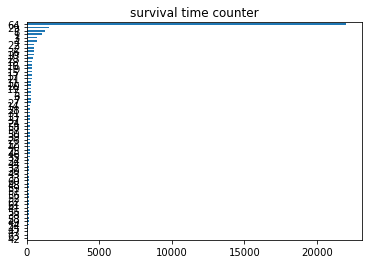

In [10]:
fig = 
merge_all['survival_time'].value_counts().sort_values().plot(kind='barh', title='survival time counter')
plt.show()

### merge_all_sub로 smote 비교

In [7]:
merge_all_sub = merge_all.copy()

In [8]:
time_freq = pd.DataFrame(merge_all_sub['survival_time'].value_counts()).reset_index()
time_freq.columns = ['survival_time', 'freq']

In [9]:
dic = {}
for i in range(1,13):
    dic[i] = 1
    
for j in range(13,30):
    dic[j] = 2
    
for z in range(30,64):
    dic[z] = 3

dic[64] = 4

time_freq['range'] = time_freq['survival_time'].map(dic)

In [10]:
time_freq.groupby('range').sum()

,survival_time,freq
range,,
1,78,6252
2,357,6307
3,1581,5445
4,64,21996


In [11]:
merge_all_sub['survival_term'] = merge_all_sub['survival_time'].map(dic)
merge_all_sub.shape

(40000, 406)

# smote가 아닌 weight를 조정해서 분석 해보기

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(merge_all_sub.drop([
                                 'amount_spent_y',
                                 'total_spent',
                                 'secession',
                                 'survival_time',
                                'survival_term'], axis=1),
                                 merge_all_sub.survival_term,
                                 test_size = 0.3, random_state=42)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28000, 401), (12000, 401), (28000,), (12000,))

In [13]:
# sample_weight에 입력 할 list 생성

# 기본 공식
# 낮은 % / 높은 % ( 둘이 합쳤을 떄 100% 기준 )

import pandas as pd
from collections import Counter

def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: round(float(majority)/float(count), 2) for cls, count in counter.items()}


# dic = get_class_weights(y_train)

# w1 = np.array(y_train.map(dic))

In [ ]:
import xgboost as xgb

np.random.seed(42)

xg_clf = xgb.XGBClassifier(colsample_bytree=0.7,
              base_score = 0.5,
              colsample_bylevel=1,
              colsample_bynode=1,
              objective='binary:logistic',
              max_delta_step=0,
              missing=None,
              n_jobs=1,
              reg_alpha=0,
              reg_lambda=1,
              scale_pos_weight=1,
              silent=None,
              nthread=4,
              gamma = 0,
              learning_rate= 0.05, 
              max_depth= 8,
              min_child_weight= 5, 
              subsample= 0.9,
              n_estimators= 1000,
               tree_method='gpu_hist',
               predictor='gpu_predictor')

# eval_set = [(X_train, y_train), (X_valid, y_valid)]
# eval_set = eval_set,

xg_clf.fit(X_train.drop('acc_id', axis=1),y_train, sample_weight = w1)

In [ ]:
y_pred = np.where(xg_clf.predict_proba(X_test.drop('acc_id', axis=1))[:,1] > 0.5, 1, 0)
# = predictions = [round(value) for value in y_pred]
precision = ((y_test == 0) & (y_pred == 0)).sum() / (y_pred == 0).sum()
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), precision, ((y_test == 0) & (y_pred == 0)).sum(),(y_pred==0).sum()

# smote 비교하기

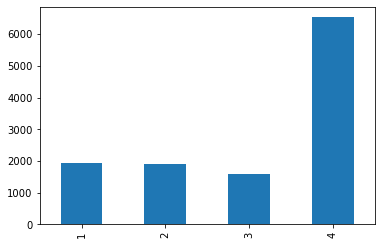

In [14]:
y_test.value_counts().sort_index().plot(kind = 'bar')

In [15]:
from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours(kind_sel = 'all', random_state=42)
X_enn, y_enn = enn.fit_resample(X_train.drop('acc_id', axis=1), y_train)

Using TensorFlow backend.


In [16]:
pd.Series(y_enn).value_counts()

4    5737
3    3851
1    1253
2     388
dtype: int64

In [17]:
from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours(kind_sel = 'mode', random_state=42)
X_enn_mode, y_enn_mode = enn.fit_resample(X_train.drop('acc_id', axis=1), y_train)

In [18]:
pd.Series(y_enn_mode).value_counts()

4    11013
3     3851
1     2286
2     1242
dtype: int64

In [34]:
dic = get_class_weights(y_enn_mode)

w1 = np.array(pd.Series(y_enn_mode).map(dic))

In [35]:
dic

{1: 4.82, 2: 8.87, 3: 2.86, 4: 1.0}

In [36]:
import xgboost as xgb

np.random.seed(42)
xg_clf = xgb.XGBClassifier(colsample_bytree=0.7,
              base_score = 0.5,
              colsample_bylevel=1,
              colsample_bynode=1,
              objective='multi:softprop',
              max_delta_step=0,
              missing=None,
              n_jobs=1,
              reg_alpha=0,
              reg_lambda=1,
              scale_pos_weight=1,
              silent=None,
              nthread=4,
              gamma = 0,
              learning_rate= 0.05, 
              max_depth= 8,
              min_child_weight= 5, 
              subsample= 0.9,
              n_estimators= 1000
#             , tree_method='gpu_hist'
#             , predictor='gpu_predictor'
                          )

# eval_set = [(X_train, y_train), (X_valid, y_valid)]
# eval_set = eval_set,

xg_clf.fit(X_enn_mode,y_enn_mode, sample_weight = w1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=5, missing=None, n_estimators=1000, n_jobs=1,
              nthread=4, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

In [38]:
from sklearn.metrics import accuracy_score, f1_score
y_pred = xg_clf.predict(np.array(X_test.drop('acc_id', axis=1)))
# = predictions = [round(value) for value in y_pred]

accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')

(0.63075, 0.6168758592459878)

0.5996924654023578


(0, 8200)

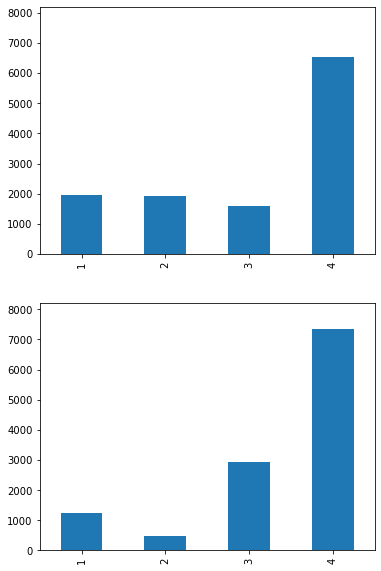

In [39]:
print(((y_pred == 1).sum()&(y_test==1).sum()) / (y_test==1).sum())
fig = plt.figure(figsize = (6,10))
ax1 = fig.add_subplot(2,1,1)
ax1 = y_test.value_counts().sort_index().plot(kind = 'bar')
ax1.set_ylim([0,8200])
ax2 = fig.add_subplot(2,1,2)
ax2 = pd.Series(y_pred).value_counts().sort_index().plot(kind = 'bar')
ax2.set_ylim([0,8200])

In [ ]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import svm

# clf = svm.SVC

ovo = OneVsOneClassifier(SVC(random_state=42))

ovo.fit(X_smotetomek,y_smotetomek)



# gamma = 'auto', 'scale'
# C = 1, 10, 100, 1000
# kernel = 'rbf'(default), 'linear', 'poly'
# verbose = 10
# random_state = 42

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
y_pred = ovo.predict(X_test)
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)

In [ ]:
# CPU version
from sklearn import svm

svc_clf = svm.SVC(C = 1, kernel = 'poly', gamma = 'auto', class_weight = 'balanced', random_state = 42)

svc_clf.fit(X_enn_mode, y_enn_mode)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
y_pred = ovo.predict(X_test)
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)

In [40]:
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import ExtraTreesClassifier

np.random.seed(42)

# eval_set = [(X_train, y_train), (X_valid, y_valid)]

OVR = OneVsRestClassifier(ExtraTreesClassifier(n_estimators = 1000, max_depth = 20,
                                 criterion = 'gini', random_state = 42))

                          

OVR.fit(X_enn_mode, y_enn_mode)

print('One vs Rest accuracy : %f' % OVR.score(X_enn_mode, y_enn_mode))

One vs Rest accuracy : 1.000000


In [41]:
from sklearn.metrics import accuracy_score, f1_score
y_pred = OVR.predict(X_test.drop('acc_id', axis=1))
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')

(0.6495833333333333, 0.612057854937127)

0.601742696053306


(0, 8200)

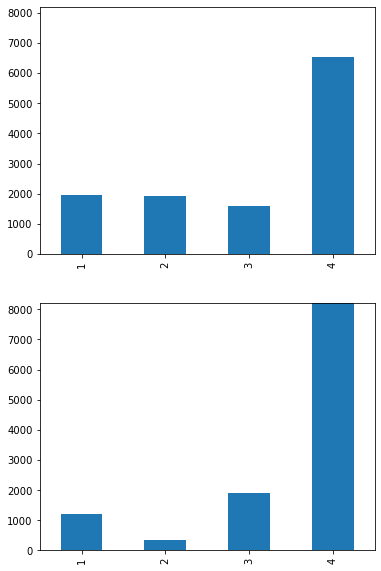

In [42]:
print(((y_pred == 1).sum()&(y_test==1).sum()) / (y_test==1).sum())
fig = plt.figure(figsize = (6,10))
ax1 = fig.add_subplot(2,1,1)
ax1 = y_test.value_counts().sort_index().plot(kind = 'bar')
ax1.set_ylim([0,8200])
ax2 = fig.add_subplot(2,1,2)
ax2 = pd.Series(y_pred).value_counts().sort_index().plot(kind = 'bar')
ax2.set_ylim([0,8200])